In [1]:

from google.colab import drive
drive.mount('/content/drive')

%ls


Mounted at /content/drive
drive/  sample_data/


In [2]:
%cd /content/drive/MyDrive/UCSP/IX CICLO/Molecular/ensamblaje de ADN
%ls

/content/drive/MyDrive/UCSP/IX CICLO/Molecular/ensamblaje de ADN
'assembly of dna fragments.ipynb'


In [3]:
%%writefile  main.cpp
#include <iostream>
#include <vector>
#include <string>
#include <algorithm>
#include <unordered_map>
#include <cmath>
#include <limits>

using namespace std;

// Función para encontrar el complemento reverso de una secuencia
string reverseComplement(const string& seq) {
    string result = seq;
    reverse(result.begin(), result.end());
    for (char& c : result) {
        switch (c) {
            case 'A': c = 'T'; break;
            case 'T': c = 'A'; break;
            case 'C': c = 'G'; break;
            case 'G': c = 'C'; break;
        }
    }
    return result;
}

// Calcula el máximo solapamiento entre dos secuencias
int calculateOverlap(const string& a, const string& b) {
    for (int i = min(a.length(), b.length()); i > 0; --i) {
        if (a.substr(a.length() - i) == b.substr(0, i)) {
            return i;
        }
    }
    return 0;
}

// Función para encontrar la secuencia de consenso
string findConsensusSequence(const vector<string>& sequences, int targetLength) {
    vector<string> allSeqs = sequences;
    for (const auto& seq : sequences) {
        allSeqs.push_back(reverseComplement(seq));
    }

    string consensus;
    vector<bool> used(allSeqs.size(), false);

    // Comienza con la secuencia más larga
    auto it = max_element(allSeqs.begin(), allSeqs.end(),
                          [](const string& a, const string& b) { return a.length() < b.length(); });
    consensus = *it;
    used[it - allSeqs.begin()] = true;

    while (consensus.length() < targetLength) {
        int bestOverlap = 0;
        string bestSeq;
        bool prepend = false;

        for (int i = 0; i < allSeqs.size(); ++i) {
            if (!used[i]) {
                int overlapStart = calculateOverlap(consensus, allSeqs[i]);
                int overlapEnd = calculateOverlap(allSeqs[i], consensus);

                if (overlapStart > bestOverlap) {
                    bestOverlap = overlapStart;
                    bestSeq = allSeqs[i];
                    prepend = false;
                }

                if (overlapEnd > bestOverlap) {
                    bestOverlap = overlapEnd;
                    bestSeq = allSeqs[i];
                    prepend = true;
                }
            }
        }

        if (bestOverlap == 0) break;

        if (prepend) {
            consensus = bestSeq.substr(0, bestSeq.length() - bestOverlap) + consensus;
        } else {
            consensus += bestSeq.substr(bestOverlap);
        }

        used[find(allSeqs.begin(), allSeqs.end(), bestSeq) - allSeqs.begin()] = true;
    }

    // Ajusta la longitud a targetLength
    if (consensus.length() > targetLength) {
        int excess = consensus.length() - targetLength;
        consensus = consensus.substr(excess / 2, targetLength);
    } else while (consensus.length() < targetLength) {
            consensus += 'N';
        }

    return consensus;
}

// Función para construir el grafo de overlaps
vector<vector<int>> buildOverlapGraph(const vector<string>& sequences, int t) {
    int n = sequences.size();
    vector<vector<int>> graph(n, vector<int>(n, 0));

    for (int i = 0; i < n; ++i) {
        for (int j = 0; j < n; ++j) {
            if (i != j) {
                int overlap = calculateOverlap(sequences[i], sequences[j]);
                if (overlap >= t) {
                    graph[i][j] = overlap; // Guardar el peso de la arista (el solapamiento)
                }
            }
        }
    }

    return graph;
}

// Función para visualizar el grafo de overlaps
void visualizeGraph(const vector<string>& sequences, const vector<vector<int>>& graph) {
    int n = sequences.size();
    for (int i = 0; i < n; ++i) {
        for (int j = 0; j < n; ++j) {
            if (graph[i][j] > 0) {
                cout << sequences[i] << " conecta con " << sequences[j]
                     << " con un peso de " << graph[i][j] << endl;
            }
        }
    }
}

// Función Greedy para buscar el camino Hamiltoniano
string findHamiltonianPath(const vector<string>& sequences, const vector<vector<int>>& graph) {
    int n = sequences.size();
    vector<bool> visited(n, false);
    string result;

    // Empieza con el primer nodo no visitado
    int current = 0;
    visited[current] = true;
    result = sequences[current];

    for (int step = 1; step < n; ++step) {
        int bestNext = -1;
        int bestWeight = 0;

        // Busca la siguiente mejor arista (máximo solapamiento)
        for (int i = 0; i < n; ++i) {
            if (!visited[i] && graph[current][i] > bestWeight) {
                bestWeight = graph[current][i];
                bestNext = i;
            }
        }

        if (bestNext == -1) break; // No hay más aristas válidas

        // Agrega la secuencia al resultado
        result += sequences[bestNext].substr(bestWeight);
        visited[bestNext] = true;
        current = bestNext;
    }

    return result;
}

int main() {
    // Conjunto de secuencias
    vector<string> sequences = {
            "ATCCGTTGAAGCCGCGGGC",
            "TTAACTCGAGG",
            "TTAAGTACTGCCCG",
            "ATCTGTGTCGGG",
            "CGACTCCCGACACA",
            "CACAGATCCGTTGAAGCCGCGGG",
            "CTCGAGTTAAGTA",
            "CGCGGGCAGTACTT"
    };

    int targetLength = 55;
    int linkageT = 3; // Definir valor de linkage t

    // Encuentra la secuencia de consenso
    string consensusSequence = findConsensusSequence(sequences, targetLength);
    cout << "Secuencia de consenso (longitud " << consensusSequence.length() << "):" << endl;
    cout << consensusSequence << endl;

    // Construye el grafo de overlaps
    vector<vector<int>> overlapGraph = buildOverlapGraph(sequences, linkageT);

    // Visualiza el grafo
    cout << "\nVisualizacion del grafo de overlaps:" << endl;
    visualizeGraph(sequences, overlapGraph);

    // Busca el camino Hamiltoniano
    string hamiltonianPath = findHamiltonianPath(sequences, overlapGraph);
    cout << "\nCamino Hamiltoniano encontrado:" << endl;
    cout << hamiltonianPath << endl;

    return 0;
}


Writing main.cpp


In [4]:
!g++ main.cpp -o main
!./main

Secuencia de consenso (longitud 55):
AGTACTGCCCGACTCCCGACACAGATCCGTTGAAGCCGCGGGCAGTACTTAACTC

Visualizacion del grafo de overlaps:
ATCCGTTGAAGCCGCGGGC conecta con CGCGGGCAGTACTT con un peso de 7
CGACTCCCGACACA conecta con CACAGATCCGTTGAAGCCGCGGG con un peso de 4
CACAGATCCGTTGAAGCCGCGGG conecta con ATCCGTTGAAGCCGCGGGC con un peso de 18
CACAGATCCGTTGAAGCCGCGGG conecta con CGCGGGCAGTACTT con un peso de 6
CTCGAGTTAAGTA conecta con TTAAGTACTGCCCG con un peso de 7

Camino Hamiltoniano encontrado:
ATCCGTTGAAGCCGCGGGCAGTACTT


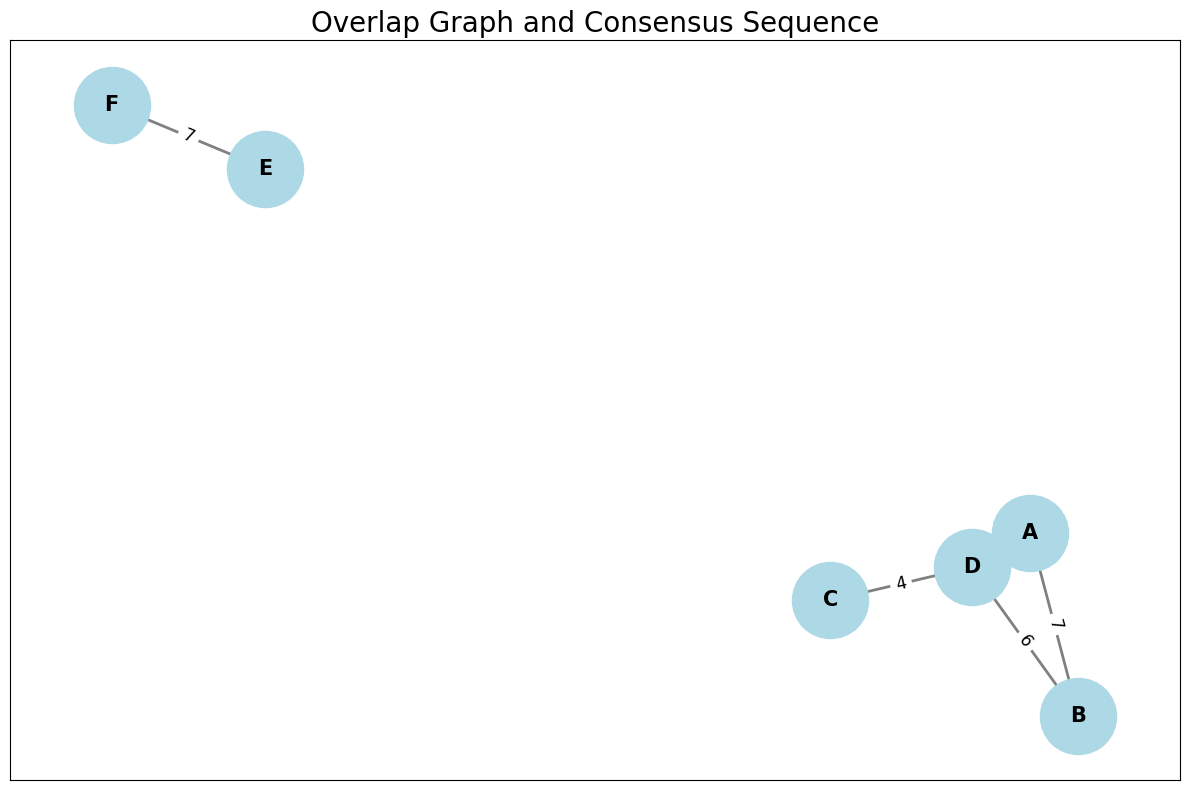

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

# Crear un grafo dirigido
G = nx.DiGraph()

# Añadir los nodos (secuencias)
"""
A: ATCCGTTGAAGCCGCGGGC
B: CGCGGGCAGTACTT
C: CGACTCCCGACACA
D: CACAGATCCGTTGAAGCCGCGGG
E: CTCGAGTTAAGTA
F: TTAAGTACTGCCCG
"""
nodos = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F"
]

# Añadir los arcos (conexiones entre nodos con el peso del overlap)
arcos = [
    ("A", "B", 7),
    ("C", "D", 4),
    ("D", "A", 18),
    ("D", "B", 6),
    ("E", "F", 7)
]

# Añadir nodos al grafo
G.add_nodes_from(nodos)

# Añadir arcos con pesos
for arco in arcos:
    G.add_edge(arco[0], arco[1], weight=arco[2])

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Aumentar tamaño de la figura

# Posición de los nodos, aumentando k para una mayor separación
pos = nx.spring_layout(G, seed=42, k=0.8)  # Aumentar k para separar más los nodos

# Dibujar los nodos con un tamaño mayor
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue')

# Dibujar los arcos con flechas más grandes y líneas más gruesas
nx.draw_networkx_edges(G, pos, edgelist=arcos, arrowstyle='->', arrowsize=30, edge_color='gray', width=2)

# Añadir etiquetas a los nodos con fuente más grande
nx.draw_networkx_labels(G, pos, font_size=15, font_family='sans-serif', font_weight='bold')

# Añadir etiquetas de pesos a los arcos con fuente más grande
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

# Título de la visualización con fuente más grande
plt.title('Overlap Graph and Consensus Sequence', size=20)

# Ajustar los márgenes para que todo el gráfico sea visible
plt.tight_layout()

# Mostrar el gráfico
plt.show()
